# Testing on example images

In [2]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import cv2

%matplotlib inline

In [16]:
test_image = "lib/datasets/test_images/stop.png"
labelmap_path = "lib/datasets/labelmap.pbtxt"
path_to_ckpt = "lib/models/inference_graph/frozen_inference_graph.pb"
num_classes=46
id=36
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
label_map = label_map_util.load_labelmap(labelmap_path)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [17]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_ckpt, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

In [18]:
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
num_detections = detection_graph.get_tensor_by_name('num_detections:0')
image = cv2.imread(test_image)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

In [19]:
scoress = np.squeeze(scores)
classess = np.squeeze(classes).astype(np.int32)
boxess = np.squeeze(boxes)

In [32]:
tmp = np.array([1,2,3,4])
test = np.where(tmp > 2)[0]
test

array([2, 3], dtype=int64)

In [20]:
test = []
for i in range(len(scoress)):
    if scoress[i] > 0.5:
        test.append(i)

In [33]:
image.shape, width, height

((1080, 1920, 3), 1920, 1080)

0
1


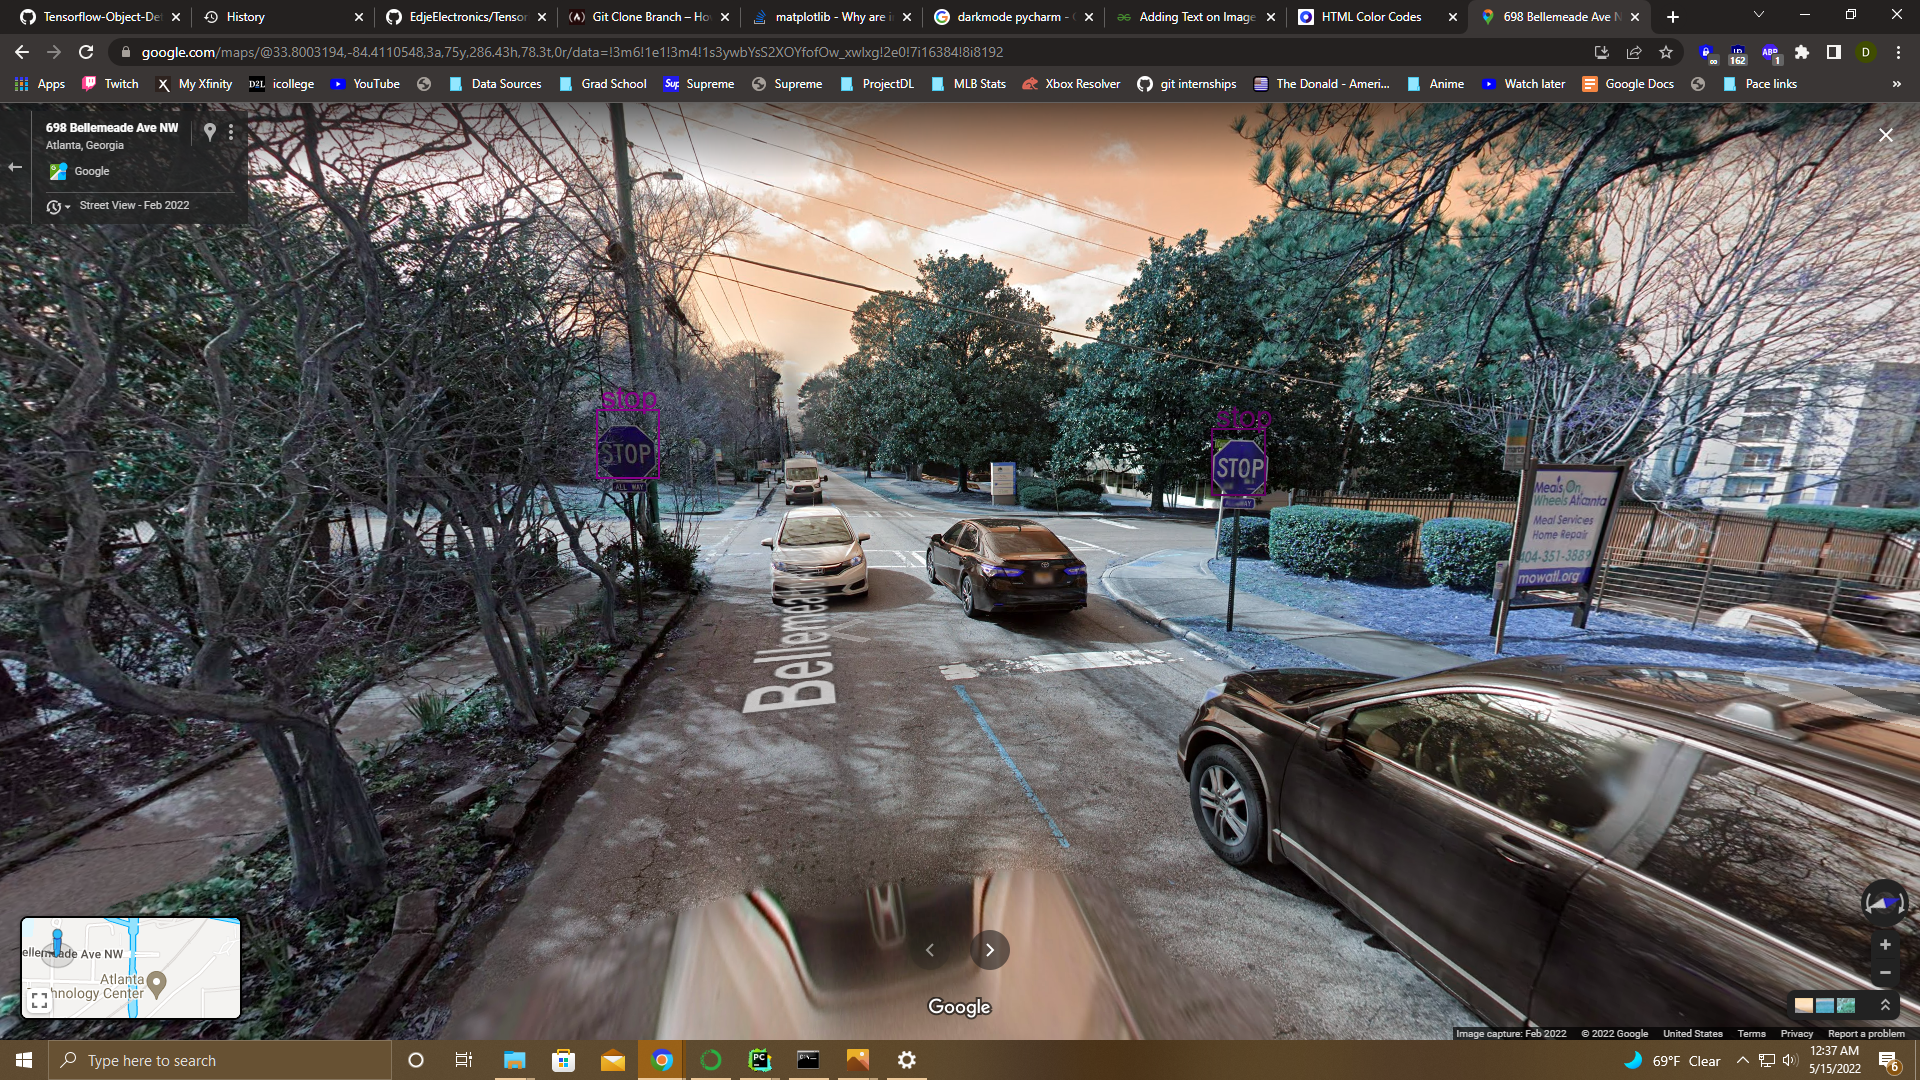

In [26]:
image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
width, height = image_pil.size
for i in test:
    print(i)
    color = (100+i*int(155/4), 0, 100+i*int(155/4))
    class_name = category_index[classess[i]]['name']
    bbox = boxess[i]
    ymin, xmin, ymax, xmax = bbox
    (left, right, top, bottom) = (int(xmin * width), int(xmax * width), int(ymin * height), int(ymax * height))
    draw = ImageDraw.Draw(image_pil)
    draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=2, fill=color)
    font = ImageFont.truetype("arial.ttf", 30)
    draw.text((int(left+5),int(top-30)), class_name, fill=color, font=font)
image_pil